In [168]:
%%capture

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

In [169]:
pic_num = 2
input_image = f'../data/original-images/{pic_num}.jpg'
output_folder = f'../report_images/image{pic_num}'

In [170]:
model = tf.keras.models.load_model('../models/1816.keras')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,256,072 (27.68 MB)

 Trainable params: 2,418,690 (9.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,837,382 (18.45 MB)

In [171]:
def partition_image(image_path, tile_size=64, output_folder='tiles'):
    image = Image.open(image_path)
    img_width, img_height = image.size

    num_tiles_x = img_width // tile_size
    num_tiles_y = img_height // tile_size

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    image.save(f'{output_folder}/full.png')

    # Loop through the image and create tiles
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            left = i * tile_size
            upper = j * tile_size
            right = left + tile_size
            lower = upper + tile_size
            box = (left, upper, right, lower)
            tile = image.crop(box)
            tile.save(f"{output_folder}/tile_{i}_{j}.png")
    
    return num_tiles_x, num_tiles_y

# Example usage
grid_size = partition_image(input_image, tile_size=64, output_folder=output_folder)

In [172]:
train_images = [Image.open(f'{output_folder}/tile_{y}_{x}.png') for y in range(grid_size[0]) for x in
                range(grid_size[1])]

train_images = np.array(train_images)

train_predictions = model.predict(train_images)
train_predicted_labels = np.array(tf.argmax(train_predictions, axis=1))
waldo_matrix = train_predicted_labels.reshape(grid_size)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Found 2 Waldos:


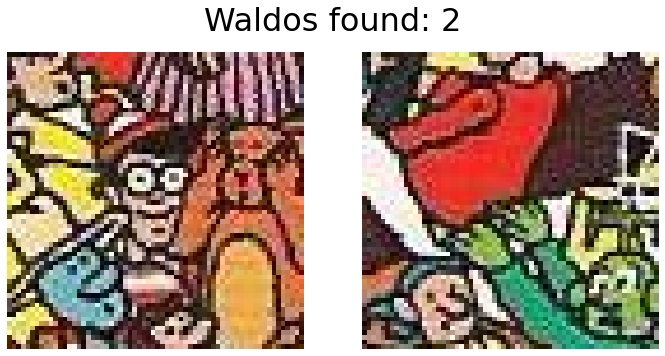

In [173]:
waldo_idx = np.where(train_predicted_labels == 1)[0]
images = train_images[waldo_idx]

waldo_num = images.shape[0]
if waldo_num == 0:
    print("No Waldo Found! :(")
else:
    N = min(images.shape[0], 6)
    M = (images.shape[0] + N - 1) // N
    
    fig, axes = plt.subplots(M, N, figsize=(5 * N, 5 * M))
    if waldo_num == 1:
        axes.imshow(images[0])
        axes.axis('off')
    else:
        axes = axes.flatten()
        for i, im in enumerate(images):
            axes[i].imshow(im)
        for i in range(N * M):
            axes[i].axis('off')
    
    print(f'Found {waldo_num} Waldos:')
    fig.suptitle(f'Waldos found: {waldo_num}', fontsize=32)
    plt.tight_layout()

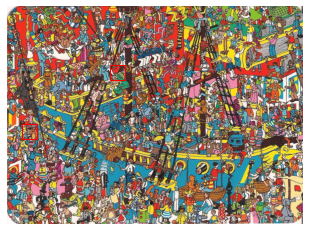

In [174]:
image = Image.open(f'{output_folder}/full.png')
image_width, image_height = image.size

fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(image)

cell_width = 64
cell_height = 64

for j in range(grid_size[0]):
    for i in range(grid_size[1]):
        if waldo_matrix[j, i] == 1:
            rect = patches.Rectangle((j * cell_width, i * cell_height), cell_width, cell_height,
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

fig.savefig(f'{output_folder}/pred.png', bbox_inches='tight', pad_inches=0, dpi=750)
plt.show()

In [175]:
for j in range(grid_size[0]):
    for i in range(grid_size[1]):
        os.remove(f"{output_folder}/tile_{j}_{i}.png")